# Fire up

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb

/home/jiashen/env3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df    

## Level 1 Model

## Original Feature with xgboost

In [3]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

**Fit the model**

In [4]:
label = train['price_doc']*0.95 + 10
col = list(test.columns)[2:]

In [5]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [6]:
params = {
   'eta': 0.05, ## Try 0.01,3,5
   'max_depth': 5,## Try 4,5,6
   'subsample': 0.7,
   'colsample_bytree': 0.7,
   'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
     verbose_eval=50, show_stdv=True,seed=42)
print('Performance doesnt improve from: '+str(len(xgb_cvalid)))

[0]	train-rmse:7.7958e+06+45790.5	test-rmse:7.80037e+06+95632.5
[50]	train-rmse:2.39694e+06+29740.6	test-rmse:2.76631e+06+72815.9
[100]	train-rmse:2.07912e+06+23045.9	test-rmse:2.59791e+06+91770.8
[150]	train-rmse:1.97156e+06+16249.4	test-rmse:2.56523e+06+90516
[200]	train-rmse:1.89038e+06+11110.4	test-rmse:2.54726e+06+90920.8
[250]	train-rmse:1.82037e+06+10577.7	test-rmse:2.53597e+06+90514.4
[300]	train-rmse:1.76422e+06+6984.38	test-rmse:2.53101e+06+89023.5
[350]	train-rmse:1.7127e+06+5395.61	test-rmse:2.52498e+06+88739
Performance doesnt improve from: 372


Create a submission for this

In [7]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid)) ## Overfitting with all iterations?

In [8]:
pred1 = model.predict(dtest)

## Subsampled Data set with Price_SQRM (And Adjusted with average price) as the target

**I made a mistake. Treating average price as price of the whole apartment before, I thought the target was the gap. However, it is barely the price per square meters with a small adjustment. I use average price on Rubble and lower one on Rubble as the input and log averaged two and create a submission. Then, The log-averaged one is the input on stacking **

In [15]:
price = pd.read_csv('moscow_avg_price.csv')
price = price[['timestamp','moscow_avg_price_low_rub']] # or moscow_avg_price_low_rub

In [16]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')
train = train.merge(price,on='timestamp',how = 'left')
test = test.merge(price,on = 'timestamp', how = 'left')

In [17]:
fullsq_fill = np.mean(train[train['full_sq'].notnull()]['full_sq'])
train['full_sq'] = train['full_sq'].fillna(fullsq_fill)
fullsq_fill = np.mean(test[test['full_sq'].notnull()]['full_sq'])
test['full_sq'] = test['full_sq'].fillna(fullsq_fill)

In [18]:
train['moscow_avg_price_low_rub'] = train['moscow_avg_price_low_rub']/train['full_sq']
test['moscow_avg_price_low_rub'] = test['moscow_avg_price_low_rub']/test['full_sq']

In [19]:
train = train.replace(np.inf, np.nan)
test = test.replace(np.inf,np.nan)

In [20]:
# Add month-year
train['timestamp'] = pd.to_datetime(train['timestamp'])
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)
test['timestamp'] = pd.to_datetime(test['timestamp'])
month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)
# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)
week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)
# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek
test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek
# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)
test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)
train.apartment_name=train.sub_area.astype(str) + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area.astype(str) + train['metro_km_avto'].astype(str)
train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [21]:
macro_cols = ['timestamp',"balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro = pd.read_csv('macro_c.csv')[macro_cols]

In [22]:
train = train.merge(macro,how='left',on='timestamp')
test = test.merge(macro,how='left',on='timestamp')

In [23]:
def get_ratio_preschool(df):
    df['ratio_preschool'] = df['children_preschool'] / (df['children_school'] + 1)
    return df

train = get_ratio_preschool(train)
test = get_ratio_preschool(test)

def get_extra_area(df):
    df['extra_area'] = df['full_sq'] - df['life_sq']
    return df

train = get_extra_area(train)
test = get_extra_area(test)

def get_floor_ratio(df):
    df['floor_ratio'] = df['max_floor'] - df['floor']
    return df

train = get_floor_ratio(train)
test = get_floor_ratio(test)

def get_room_avg_size(df):
    df['room_avg_size'] = (df['life_sq'] - df['kitch_sq']) / (df['num_room'] + 1)
    return df

train = get_room_avg_size(train)
test = get_room_avg_size(test)

**Bold Move**

In [24]:
train = train[train.moscow_avg_price_low_rub.notnull()]
train.shape

(29262, 317)

In [26]:
Price_sqm = [x/y for x,y in zip(list(train['price_doc']*0.95+10),list(train['full_sq']))]
Price_gap = Price_sqm - train['moscow_avg_price_low_rub']

In [27]:
train['gap'] = Price_gap

**Create New Features of SQ and Drop Redundant Ones**

In [28]:
train['life_sq_ratio'] = train['life_sq']/train['full_sq']
train['kitch_sq_ratio'] = train['kitch_sq']/train['full_sq']
test['life_sq_ratio'] = test['life_sq']/test['full_sq']
test['kitch_sq_ratio'] = test['kitch_sq']/test['full_sq']

In [29]:
col = list(test.columns)[2:]
col = [each for each in col if each not in ['full_sq','life_sq','kitch_sq','moscow_avg_price_low_rub']]
label = train['gap']

In [30]:
dtrain = xgb.DMatrix(train[col],label)

In [31]:
params = {
   'eta': 0.05, ## Try 0.01,3,5
   'max_depth': 5,## Try 4,5,6
   'subsample': 0.7,
   'colsample_bytree': 0.7,
   'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
     verbose_eval=50, show_stdv=True,seed=42)
print(len(xgb_cvalid))

[0]	train-rmse:131050+620.161	test-rmse:131056+1259.98
[50]	train-rmse:34578.5+408.886	test-rmse:37298.3+1802.16
[100]	train-rmse:30580.4+334.256	test-rmse:35133.4+1772.36
[150]	train-rmse:28922.2+320.155	test-rmse:34832.7+1779.85
[200]	train-rmse:27652.4+330.426	test-rmse:34679.4+1764.58
[250]	train-rmse:26589.6+284.936	test-rmse:34593+1777.9
[300]	train-rmse:25665.7+334.183	test-rmse:34522.8+1764.4
[350]	train-rmse:24851.6+319.374	test-rmse:34487.1+1786.76
[400]	train-rmse:24122.3+318.022	test-rmse:34483.3+1789.35
407


In [32]:
#dtrain = xgb.DMatrix(train[col],label)
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [33]:
feature_importance = get_feature_importance(model).iloc[0:20,:]

In [34]:
feature_importance

,Feature,Score
134,floor,455
264,extra_area,410
251,build_year,345
131,max_floor,345
42,life_sq_ratio,240
281,month_year_cnt,180
38,num_room,163
101,week_year_cnt,150
28,rel_kitch_sq,146
249,material,132


In [35]:
dtest = xgb.DMatrix(test[col])

In [36]:
pred = model.predict(dtest)
Actual_predict = (pred+test['moscow_avg_price_low_rub'])*test['full_sq']

**Use Average Price in dataset to repeat the above procedure again, Then take the log-average of two predictions.**

## Model with sub_area average price as input

**Just downloaded submission file on May 30 and do it directly.**

# Weighted Averaged Results

In [37]:
from ggplot import *

**Sub1 and 2 are two files that use different fields in moscow prices data set to adjust the price per square meter. First, log-average those two files.**

In [38]:
sub1 = pd.read_csv('xgb+additional+subsampled+average_price+0.95label.csv')
sub2 = pd.read_csv('xgb+additional+subsampled+low_average_price+0.95label.csv')

In [39]:
def compare_results(sub1,sub2):
    diff = sub1['price_doc'] - sub2['price_doc']
    tmp = pd.DataFrame({'id':sub1['id'],'diff':diff})
    g = ggplot(tmp,aes(x='id',y='diff'))+geom_line()
    print(g)

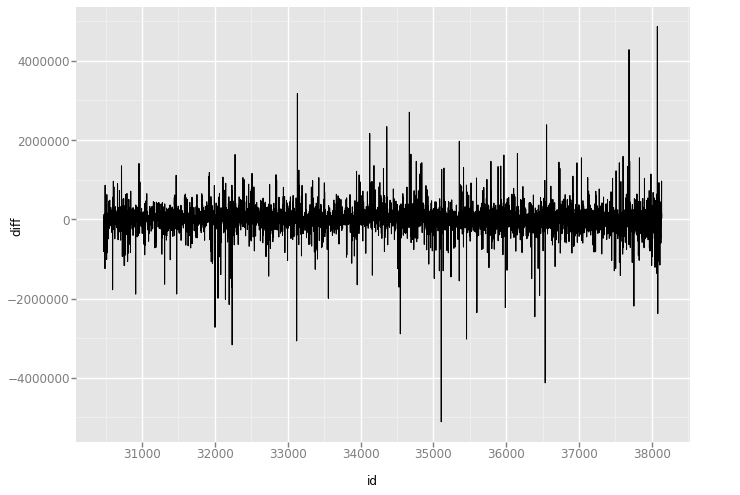

<ggplot: (8779151706011)>


In [40]:
compare_results(sub1,sub2)

In [41]:
Log_Averaged = np.exp(np.log(sub1['price_doc'])*0.5+np.log(sub2['price_doc'])*0.5)
sub_two_gap2 = pd.DataFrame({'id':sub1['id'],'price_doc':Log_Averaged})

**Use the best base model's output as input**

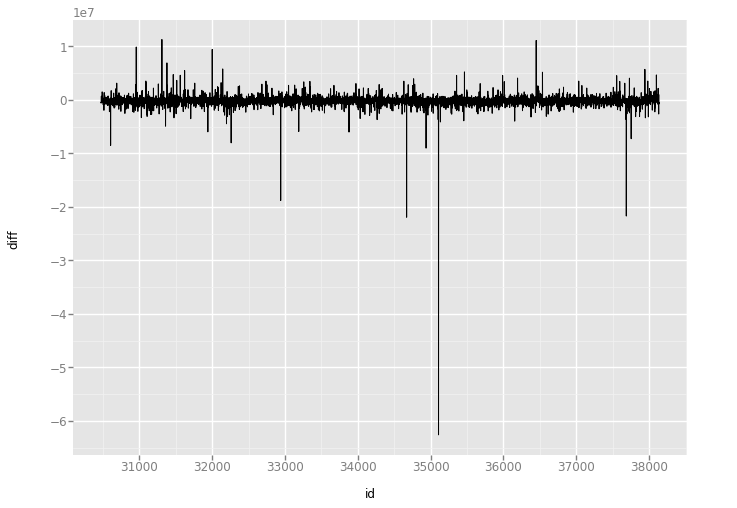

<ggplot: (8779149536022)>


In [42]:
sub3 = pd.read_csv('xgb_0.95label.csv')
compare_results(sub3,sub_two_gap2)

**sub_log_have2 is the 155nd result**

In [44]:
Log_Average = np.exp(np.log(sub3['price_doc'])*0.5+np.log(Log_Averaged)*0.5)
sub_logave_two = pd.DataFrame({'id':sub1['id'],'price_doc':Log_Average})

**Third input**

In [46]:
sub4 = pd.read_csv('submission_20170530_avg_subarea_price.csv')

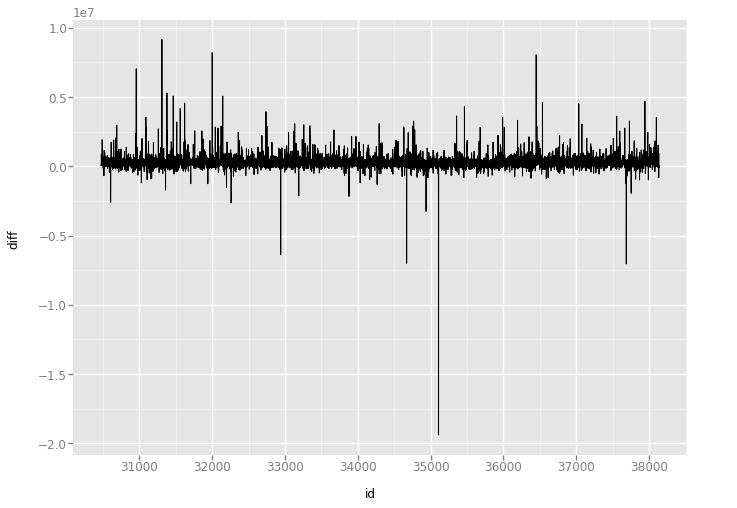

<ggplot: (-9223363257705195702)>


In [47]:
compare_results(sub4,sub_logave_two)

In [48]:
Log_Average2 = np.exp(np.log(sub4['price_doc'])*0.3+np.log(sub_logave_two['price_doc'])*0.7)

In [49]:
sub_logave_three = pd.DataFrame({'id':sub1['id'],'price_doc':Log_Average2})

**This is the current best out-put**